<a href="https://colab.research.google.com/github/MerkulovDaniil/optim/blob/master/assets/Notebooks/NN_Surface_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --quiet clu

# Train/load model

In [4]:
import tensorflow_datasets as tfds      # TFDS for MNIST
import tensorflow as tf                 # TensorFlow operations
from flax import linen as nn            # Linen API
import jax
import jax.numpy as jnp                # JAX NumPy
import numpy as np
from clu import metrics
from flax.training import train_state   # Useful dataclass to keep train state
from flax import struct                 # Flax dataclasses
import optax                           # Common loss functions and optimizers
import matplotlib.pyplot as plt        # Visualization
import random
from tqdm.auto import tqdm
from jax import vmap
seed = 228
from typing import Sequence
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots

In [5]:
def get_datasets(num_epochs, batch_size, seed=seed):
  """Load MNIST train and test datasets into memory."""
  tf.random.set_seed(seed)
  train_ds = tfds.load('fashion_mnist', split='train')
  test_ds = tfds.load('fashion_mnist', split='test')

  train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                           tf.float32) / 255.,
                                          'label': sample['label']}) # normalize
                                                                     # train set
  test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                         tf.float32) / 255.,
                                        'label': sample['label']}) # normalize
                                                                   # test set

  # create shuffled dataset by allocating a buffer size of 1024 to randomly
  # draw elements from
  train_ds = train_ds.repeat(num_epochs).shuffle(1024, seed=seed,
                                                 reshuffle_each_iteration=False)

  # group into batches of batch_size and skip incomplete batch, prefetch the
  # next sample to improve latency
  train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)

  # create shuffled dataset by allocating a buffer size of 1024 to randomly
  #draw elements from
  test_ds = test_ds.shuffle(1024, seed=seed, reshuffle_each_iteration=False)

  # group into batches of batch_size and skip incomplete batch, prefetch the
  # next sample to improve latency
  test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

  return train_ds, test_ds


class CNN(nn.Module):
  """A simple CNN model."""
  dropout_rate: float

  @nn.compact
  def __call__(self, x, training: bool):
    x = nn.Conv(features=16, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
    x = nn.Dense(features=64)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

class MLP(nn.Module):
  features: Sequence[int]
  dropout_rate: float

  @nn.compact
  def __call__(self, x, training: bool):
    x = x.reshape((x.shape[0], -1))  # flatten
    for feat in self.features[:-1]:
      x = nn.gelu(nn.Dense(feat)(x))
      x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
    x = nn.Dense(self.features[-1])(x)
    return x

@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
  rng: jax.random.KeyArray
  metrics: Metrics

def create_train_state(module, params_rng, dropout_rng,
                       learning_rate, momentum,
                       input=jnp.ones([1, 28, 28, 1])):
  """Creates an initial `TrainState`."""
  # initialize parameters by passing a template image
  params = module.init(params_rng, input, training=False)['params']
  tx = optax.sgd(learning_rate, momentum)
  return TrainState.create(
      apply_fn=module.apply,
      params=params,
      tx=tx,
      metrics=Metrics.empty(),
      rng=dropout_rng)

@jax.jit
def train_step(state, batch, dropout_rng):
  """Train for a single step."""
  dropout_train_rng = jax.random.fold_in(key=dropout_rng, data=state.step)
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image'], training=True,
                            rngs={'dropout': dropout_train_rng})
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'],
                          training=False)
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch['label'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

def print_model(model, input=jnp.ones((1, 28, 28, 1))):
    print(model.tabulate(jax.random.PRNGKey(0), input, training=False))

def fix_seed(seed=seed):
    random.seed(seed)
    tf.random.set_seed(seed)

def calculate_metrics(state, train_ds, test_ds, metrics_history):
    for step, batch in enumerate(train_ds.as_numpy_iterator()):

            # aggregate batch metrics
            state = compute_metrics(state=state, batch=batch)

            # one training epoch has passed
            if (step+1) % num_steps_per_epoch == 0:
                # compute metrics
                for metric,value in state.metrics.compute().items():
                    # record metrics
                    metrics_history[f'train_{metric}'].append(value)

                # reset train_metrics for next training epoch
                state = state.replace(metrics=state.metrics.empty())

                # Compute metrics on the test set after each training epoch
                test_state = state
                for test_batch in test_ds.as_numpy_iterator():
                    test_state = compute_metrics(state=test_state,
                                                 batch=test_batch)

                for metric,value in test_state.metrics.compute().items():
                    metrics_history[f'test_{metric}'].append(value)

                break
    return metrics_history

def train_model_from_scratch(state, train_ds, test_ds, metrics_history,
                             dropout_rng):
    for step,batch in enumerate(train_ds.as_numpy_iterator()):
        # Run optimization steps over training batches and compute batch metrics
        # get updated train state (which contains the updated parameters)
        state = train_step(state, batch, dropout_rng)
        # print(f"💎 Dense_0 norm {jnp.linalg.norm(state.params['Dense_0']['kernel'])}")

        # aggregate batch metrics
        state = compute_metrics(state=state, batch=batch)

        if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
            # compute metrics
            for metric,value in state.metrics.compute().items():
                # record metrics
                metrics_history[f'train_{metric}'].append(value)

            # reset train_metrics for next training epoch
            state = state.replace(metrics=state.metrics.empty())

            # Compute metrics on the test set after each training epoch
            test_state = state
            for test_batch in test_ds.as_numpy_iterator():
                test_state = compute_metrics(state=test_state, batch=test_batch)

            for metric,value in test_state.metrics.compute().items():
                metrics_history[f'test_{metric}'].append(value)

            print(f"💎 Epoch: {(step+1) // num_steps_per_epoch}, \n"
                f"train loss: "
                f"{metrics_history['train_loss'][-1]:.3f}, "
                f"train accuracy: "
                f"{metrics_history['train_accuracy'][-1] * 100:.2f}")
            print(f"test loss: {metrics_history['test_loss'][-1]:.3f}, "
                f"test accuracy: "
                f"{metrics_history['test_accuracy'][-1] * 100:.2f}")

    return state, metrics_history

def plot_history(experiments, title=""):
    colors  = iter(["b", "g", "r", "c", "m", "y", "k", "w"])
    markers = iter(["o", "v", "^", "<", ">", "s", "p", "*"])
    # Plot loss and accuracy in subplots
    fig, axs = plt.subplot_mosaic(
    '''
    AB
    CD
    ''', figsize=(12, 9)
    )

    plt.suptitle(title)

    metric_to_title = {
        "train_loss": "Train loss",
        "test_loss": "Test loss",
        "train_accuracy": "Train accuracy",
        "test_accuracy": "Test accuracy"
    }

    metric_to_ax = {
        "train_loss": "A",
        "test_loss": "B",
        "train_accuracy": "C",
        "test_accuracy": "D"
    }

    for exp_key in experiments.keys():

        metrics_history = experiments[exp_key]["metrics"]

        c, m = next(colors), next(markers)
        for metric_name, metric_values in metrics_history.items():
            ax = metric_to_ax[metric_name]
            title = metric_to_title[metric_name]

            axs[ax].set_title(title)
            axs[ax].grid(linestyle=":")
            axs[ax].plot(metric_values, color=c)
            axs[ax].set_xlabel("Epoch")
            axs[ax].scatter(range(len(metric_values)), metric_values,
                            color=c, marker=m, label=exp_key)

    axs[ax].legend()
    plt.savefig("result.svg")
    plt.show()

In [6]:
num_epochs = 25
batch_size = 512
seed = 228
learning_rate = 0.01
momentum = 0.9
dropout_rate = 0.2
fix_seed(seed)

experiments = dict.fromkeys(["No Dropout", f"Dropout {dropout_rate}"]) #, f"Dropout {dropout_rate}"

train_ds, test_ds = get_datasets(num_epochs, batch_size)
init_rng = jax.random.PRNGKey(seed)
rng, params_rng, dropout_rng = jax.random.split(key=init_rng, num=3)

for exp_key in experiments.keys():
    print(f"💎 Experiment: {exp_key}")
    experiments[exp_key] = {}
    metrics_history =  {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

    if exp_key == "No Dropout" or exp_key == "No Dropout2":
        model = CNN(dropout_rate=0.0)
        # model = MLP([128, 64, 32, 16, 10], dropout_rate=0.0)
        # model = MLP([100, 80, 60, 40, 30, 20, 16, 14, 12, 10], dropout_rate=0.0)
    elif exp_key == f"Dropout {dropout_rate}":
        model = CNN(dropout_rate=dropout_rate)
        # model = MLP([128, 64, 32, 16, 10], dropout_rate=dropout_rate)
        # model = MLP([100, 80, 60, 40, 30, 20, 16, 14, 12, 10], dropout_rate=dropout_rate)

    print_model(model)
    state = create_train_state(model,
                            params_rng=params_rng, dropout_rng=dropout_rng,
                            learning_rate=learning_rate, momentum=momentum)
    experiments[exp_key]["initial_state"] = state
    # Before training
    # since train_ds is replicated num_epochs times in get_datasets(),
    # we divide by num_epochs
    num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs

    metrics_history = calculate_metrics(state, train_ds, test_ds, metrics_history)


    state, metrics_history = train_model_from_scratch(state, train_ds, test_ds, metrics_history, dropout_rng)

    experiments[exp_key]["metrics"] = metrics_history
    experiments[exp_key]["final_state"] = state

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteOOO33J/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteOOO33J/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
💎 Experiment: No Dropout

                                  CNN Summary                                   
┏━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path      ┃ module  ┃ inputs           ┃ outputs          ┃ params           ┃
┡━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│           │ CNN     │ -                │ float32[1,10]    │                  │
│           │         │ float32[1,28,28… │                  │                  │
│           │         │ - training:      │                  │                  │
│           │         │ False            │                  │                  │
├───────────┼─────────┼──────────────────┼──────────────────┼──────────────────┤
│ Conv_0    │ Conv    │ float32[1,28,28… │ float32[1,28,28… │ bias:            │
│           │         │      

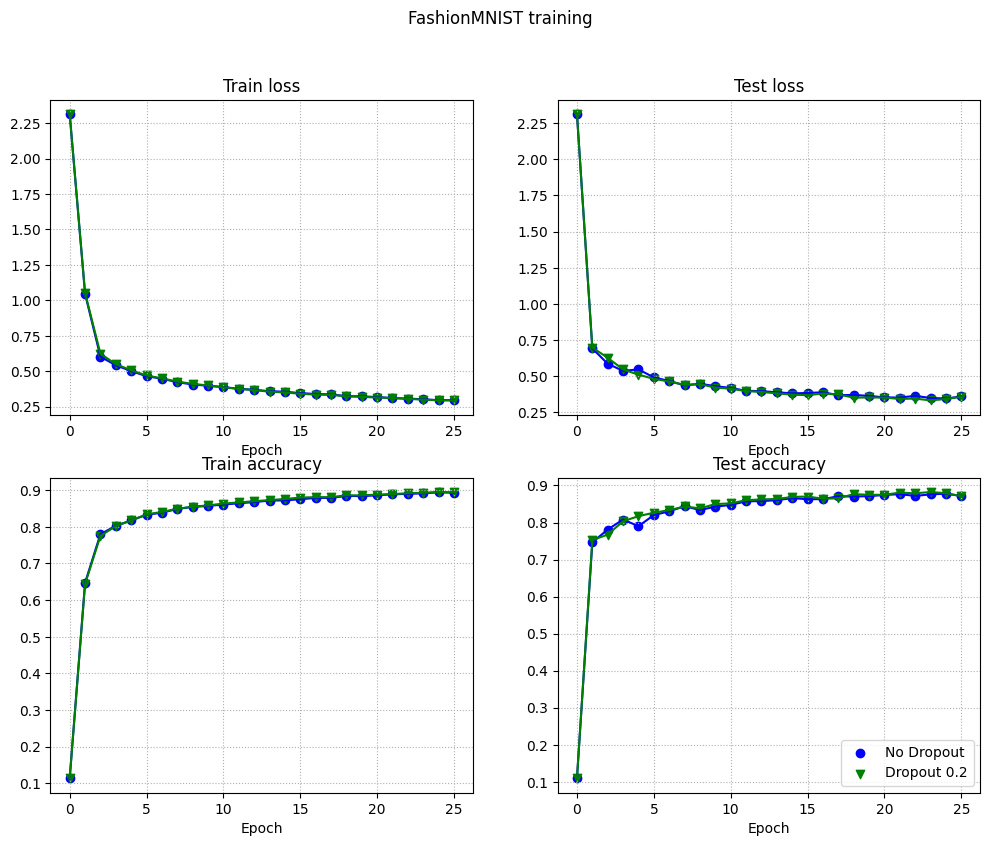

In [7]:
plot_history(experiments, "FashionMNIST training")

# Visualising loss surface

## Scalar Projection

Let's consider the training of our neural network by solving the following optimization problem:

$$
\mathcal{L} (\theta) \to \min_{\theta \in \mathbb{R}^p}
$$

We denote the initial point as $\theta_0$, representing the weights of the neural network at initialization. The weights after training are denoted as $\hat{\theta}$.

In the given example, we have $p = 105,866$, which implies that we are seeking a minimum in a 105,866-dimensional space. Exploring this space is intriguing, and the underlying concept is as follows.

Initially, we generate a random Gaussian direction $w_1 \in \mathbb{R}^p$, which inherits the magnitude of the original neural network weights for each parameter group. Subsequently, we sample the training and testing loss surfaces at points along the direction $w_1$, situated close to either $\theta_0$ or $\hat{\theta}$.

Mathematically, this involves evaluating:

$$
\mathcal{L} (\alpha) = \mathcal{L} (\theta_0 + \alpha w_1), \text{ where } \alpha \in [-b, b].
$$

Here, $\alpha$ plays the role of a coordinate along the $w_1$ direction, and $b$ stands for the bounds of interpolation. Visualizing $\mathcal{L} (\alpha)$ enables us to project the $p$-dimensional surface onto a one-dimensional axis.

It is important to note that the characteristics of the resulting graph heavily rely on the chosen projection direction. It's not feasible to maintain the entirety of the informationWhen transforming a space with 100,000 dimensions into a one-dimensional line through projection. However, certain properties can still be established. For instance, if $\mathcal{L} (\alpha) \mid_{\alpha=0}$ is decreasing, this indicates that the point lies on a slope. Additionally, if the projection is non-convex, it implies that the original surface was not convex.

In [8]:
def generate_normalized_direction(state, RNG=jax.random.PRNGKey(0)):
    '''
    Generate a new params dictionary with random normalized parameters.
    '''
    theta = {}
    for module_name, module_state in state.params.items():
        theta[module_name] = {}
        for parameter_name, parameter_value in module_state.items():
            theta_ = jax.random.normal(RNG, shape=parameter_value.shape)
            parameter_norm = jnp.linalg.norm(parameter_value)
            theta_norm = jnp.linalg.norm(theta_)
            scaling_factor = parameter_norm / (theta_norm + 1e-10)
            theta_ *= scaling_factor
            theta[module_name][parameter_name] = theta_
    return theta

# Use this function if you are facing OOM GPU problems
def line_projection(state, batch, alphas=jnp.linspace(-1e-1, 1e-1, 11)):
    RNG1, _ = jax.random.split(key=init_rng, num=2)

    # Generate random direction
    w1 = generate_normalized_direction(state, RNG1)

    losses = []
    for alpha in tqdm(alphas):
        perturbed_params = jax.tree_util.tree_map(lambda a, b: a + alpha*b, state.params, w1)
        logits = state.apply_fn({'params': perturbed_params}, batch['image'], training=False,
                                rngs={'dropout': dropout_rng})
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch['label']).mean()
        losses.append(loss)

    return losses

def line_projection_vmap(state, batch, alphas=jnp.linspace(-1e-1, 1e-1, 11)):
    RNG1, _ = jax.random.split(key=init_rng, num=2)

    # Generate random direction
    w1 = generate_normalized_direction(state, RNG1)

    losses = []
    # Function to compute loss for a given alpha
    @jax.jit
    def compute_loss(alpha, state, batch):
        perturbed_params = jax.tree_map(lambda a, b: a + alpha * b, state.params, w1)
        logits = state.apply_fn({'params': perturbed_params}, batch['image'], training=False,
                                rngs={'dropout': dropout_rng})
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch['label']).mean()
        return loss

    compute_loss_vmap = vmap(lambda alpha: compute_loss(alpha, state, batch))
    losses = compute_loss_vmap(alphas)

    return losses

def plot_line_projection(alphas, losses, title='Loss surface. Line projection.', point_legend="Weights"):
    # Plot results
    plt.plot(alphas, losses["train"], label="Train")
    plt.plot(alphas, losses["test"], label="Test")
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\mathcal{L}(\theta + \alpha w_1)$')
    # Find the index where alpha is closest to 0
    index_closest_to_zero = jnp.argmin(jnp.abs(alphas))

    # Get the corresponding loss value
    loss_at_zero_alpha = losses["train"][index_closest_to_zero]

    # Plot the point at (0, loss_at_zero_alpha)
    plt.scatter(0, loss_at_zero_alpha, 100,color='red', marker='o', label=point_legend, zorder=2.5)
    plt.scatter(0, losses["test"][index_closest_to_zero], 100,color='red', marker='o', zorder=2.5)

    plt.title(title)
    plt.grid(linestyle=":")
    plt.legend(loc='upper center')

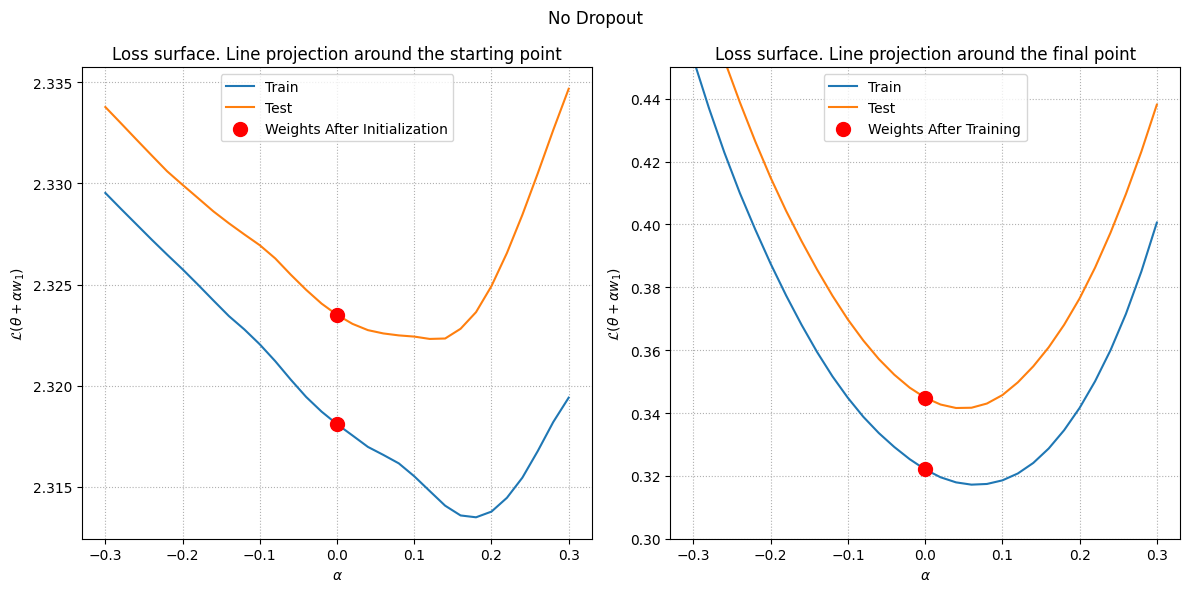

In [10]:
resolution=31
bound=3e-1
if resolution % 2 == 0:
    print("🤖 Decreasing resolution to make it odd")
    resolution -= 1

exp_key = "No Dropout"
# exp_key = f"Dropout {dropout_rate}"
alphas = jnp.linspace(-bound, bound, resolution)
train_batch = next(train_ds.as_numpy_iterator())
test_batch = next(test_ds.as_numpy_iterator())


# Plot the first graph
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # Create a subplot with 1 row, 2 columns, and select the first plot
losses = {}
losses["train"] = line_projection_vmap(experiments[exp_key]["initial_state"], train_batch, alphas)
losses["test"] = line_projection_vmap(experiments[exp_key]["initial_state"], test_batch, alphas)
plot_line_projection(alphas, losses, title='Loss surface. Line projection around the starting point', point_legend="Weights After Initialization")

# Plot the second graph
plt.subplot(1, 2, 2)  # Select the second plot
plt.ylim([0.3, 0.45]) # Only for educational purposes for very specific model
losses = {}
losses["train"] = line_projection_vmap(experiments[exp_key]["final_state"], train_batch, alphas)
losses["test"] = line_projection_vmap(experiments[exp_key]["final_state"], test_batch, alphas)
plot_line_projection(alphas, losses, title='Loss surface. Line projection around the final point', point_legend="Weights After Training")
plt.suptitle(exp_key)
plt.tight_layout()  # Ensure proper spacing between subplots
plt.savefig(f"Line_projection_{exp_key}.png", dpi=1000)
plt.show()


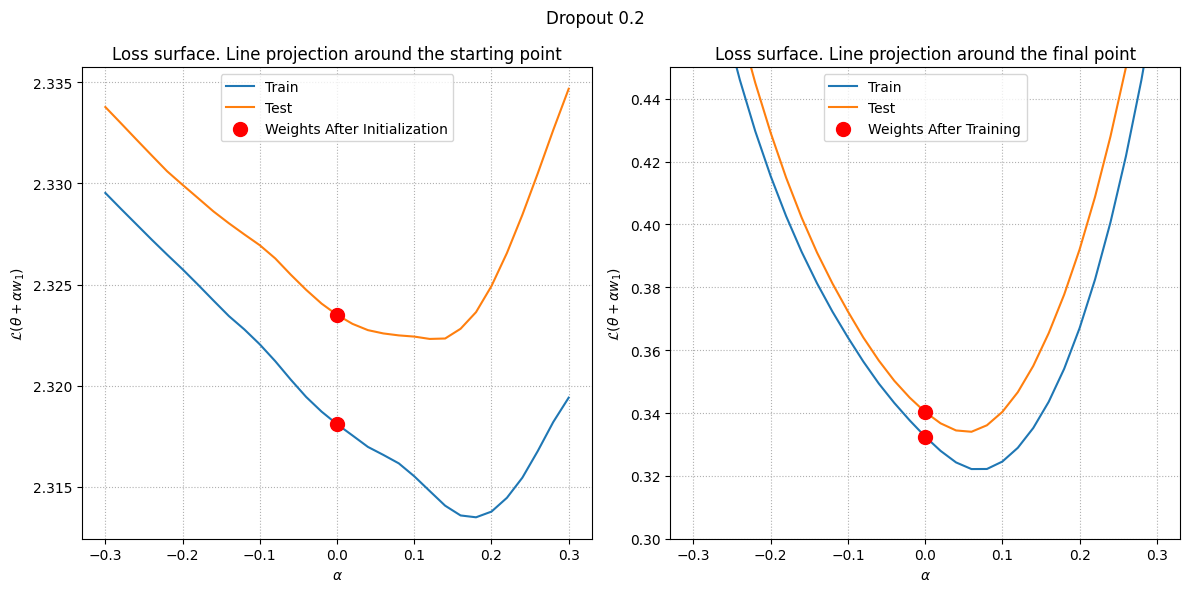

In [11]:
resolution=31
bound=3e-1
if resolution % 2 == 0:
    print("🤖 Decreasing resolution to make it odd")
    resolution -= 1

# exp_key = "No Dropout"
exp_key = f"Dropout {dropout_rate}"
alphas = jnp.linspace(-bound, bound, resolution)
train_batch = next(train_ds.as_numpy_iterator())
test_batch = next(test_ds.as_numpy_iterator())


# Plot the first graph
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.subplot(1, 2, 1)  # Create a subplot with 1 row, 2 columns, and select the first plot
losses = {}
losses["train"] = line_projection_vmap(experiments[exp_key]["initial_state"], train_batch, alphas)
losses["test"] = line_projection_vmap(experiments[exp_key]["initial_state"], test_batch, alphas)
plot_line_projection(alphas, losses, title='Loss surface. Line projection around the starting point', point_legend="Weights After Initialization")

# Plot the second graph
plt.subplot(1, 2, 2)  # Select the second plot
plt.ylim([0.3, 0.45]) # Only for educational purposes for very specific model
losses = {}
losses["train"] = line_projection_vmap(experiments[exp_key]["final_state"], train_batch, alphas)
losses["test"] = line_projection_vmap(experiments[exp_key]["final_state"], test_batch, alphas)
plot_line_projection(alphas, losses, title='Loss surface. Line projection around the final point', point_legend="Weights After Training")
plt.suptitle(exp_key)
plt.tight_layout()  # Ensure proper spacing between subplots
plt.savefig(f"Line_projection_{exp_key}.png", dpi=1000)
plt.show()

## Two dimensional projection
We can explore this idea further and draw the projection of the loss surface to the plane, which is defined by 2 random vectors. Note, that with 2 random gaussian vectors in the huge dimensional space are almost certainly orthogonal.

So, as previously, we generate random normalized gaussian vectors $w_1, w_2 \in \mathbb{R}^p$ and evaluate the loss function

$$
\mathcal{L} (\alpha, \beta) = \mathcal{L} (\theta_0 + \alpha w_1 + \beta w_2), \text{ where } \alpha, \beta \in [-b, b]^2.
$$

which immediately leads us to the following nice pictures:

In [12]:
# Use this function if you are facing OOM GPU problems
def plane_projection(state, batch,
                     alphas=jnp.linspace(-1e-1, 1e-1, 11),
                     betas=jnp.linspace(-1e-1, 1e-1, 11)):
    RNG1, RNG2 = jax.random.split(key=init_rng, num=2)

    # Generate random direction
    w1 = generate_normalized_direction(state, RNG1)
    w2 = generate_normalized_direction(state, RNG1)

    losses  = np.zeros((len(alphas), len(betas)))
    for i_alpha, alpha in tqdm(enumerate(alphas)):
        for i_beta, beta in tqdm(enumerate(betas), leave=False):
            perturbed_params = jax.tree_util.tree_map(lambda a, b, c: a + alpha*b + beta*c, state.params, w1, w2)
            logits = state.apply_fn({'params': perturbed_params}, batch['image'], training=False,
                                    rngs={'dropout': dropout_rng})
            loss = optax.softmax_cross_entropy_with_integer_labels(
                logits=logits, labels=batch['label']).mean()
            losses[i_alpha, i_beta] = loss

    return losses

# Use this function if you are facing OOM GPU problems
def plane_projection_vmap(state, batch,
                     alphas=jnp.linspace(-1e-1, 1e-1, 11),
                     betas=jnp.linspace(-1e-1, 1e-1, 11)):
    RNG1, RNG2 = jax.random.split(key=init_rng, num=2)

    # Generate random direction
    w1 = generate_normalized_direction(state, RNG1)
    w2 = generate_normalized_direction(state, RNG2)

    losses  = np.zeros((len(alphas), len(betas)))
    # Function to compute loss for a given alpha
    @jax.jit
    def compute_loss(alpha, beta, state, batch):
        perturbed_params = jax.tree_util.tree_map(lambda a, b, c: a + alpha*b + beta*c, state.params, w1, w2)
        logits = state.apply_fn({'params': perturbed_params}, batch['image'], training=False,
                                rngs={'dropout': dropout_rng})
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch['label']).mean()
        return loss

    compute_loss_vmap = vmap(lambda beta: compute_loss(alpha, beta, state, batch))

    for i_alpha, alpha in tqdm(enumerate(alphas)):
        losses[i_alpha, :] = compute_loss_vmap(betas)

    return losses

In [13]:
def get_surface_data(exp_key, state_key, batch):
    return plane_projection_vmap(experiments[exp_key][state_key], batch, alphas, betas)

resolution=51
bound=3e-1
if resolution % 2 == 0:
    print("🤖 Decreasing resolution to make it odd")
    resolution -= 1

exp_key = "No Dropout"
# exp_key = f"Dropout {dropout_rate}"
alphas = jnp.linspace(-bound, bound, resolution)
betas = jnp.linspace(-bound, bound, resolution)
train_batch = next(train_ds.as_numpy_iterator())
test_batch = next(test_ds.as_numpy_iterator())

# Initial State Data
z_train_initial = get_surface_data(exp_key, "initial_state", train_batch)
z_test_initial = get_surface_data(exp_key, "initial_state", test_batch)

# Final State Data
z_train_final = get_surface_data(exp_key, "final_state", train_batch)
z_test_final = get_surface_data(exp_key, "final_state", test_batch)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [14]:
def add_surface_to_figure(fig, row, col, x, y, z_train_data, z_test_data, coloraxis, marker_title="Weights"):
    # Calculate the color range for this surface
    min_value = min(z_train_data.min(), z_test_data.min())
    max_value = max(z_train_data.max(), z_test_data.max())

    # Add train loss surface
    fig.add_trace(go.Surface(z=z_train_data, x=x, y=y, colorscale='RdBu',
                             cmin=min_value, cmax=max_value, coloraxis=coloraxis,
                             hovertemplate='α: %{x:.2f}<br>β: %{y:.2f}<br>Train Loss: %{z:.2f}',
                             showlegend=True,
                             name='Train Loss'),
                  row=row, col=col)

    # Add test loss surface
    fig.add_trace(go.Surface(z=z_test_data, x=x, y=y, colorscale='RdBu',
                             cmin=min_value, cmax=max_value, coloraxis=coloraxis,
                             hovertemplate='α: %{x:.2f}<br>β: %{y:.2f}<br>Test Loss: %{z:.2f}',
                             showlegend=True,
                             name='Test Loss'),
                  row=row, col=col)

    # Find indices where alpha and beta are closest to 0
    index_alpha_zero = np.argmin(np.abs(x))
    index_beta_zero = np.argmin(np.abs(y))

    # Extract the corresponding z values for train and test data
    z_train_at_zero = z_train_data[index_alpha_zero, index_beta_zero]
    z_test_at_zero = z_test_data[index_alpha_zero, index_beta_zero]

    # Add center point marker for train data
    fig.add_trace(go.Scatter3d(x=[0, 0], y=[0, 0], z=[z_train_at_zero, z_test_at_zero],
                               mode='markers',
                               marker=dict(size=5, color='red', symbol='circle'),
                               showlegend=True if row==1 else False,
                               name=marker_title if row==1 else None),
                  row=row, col=col)

# Create a subplot figure
fig = go.FigureWidget(make_subplots(rows=1, cols=2,
                                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                                    subplot_titles=(f'Before training', f'After training')))

# Add initial state surfaces to the figure
add_surface_to_figure(fig, 1, 1, alphas, betas, z_train_initial, z_test_initial,
                      'coloraxis1', "Weights before training")

# Add final state surfaces to the figure
add_surface_to_figure(fig, 1, 2, alphas, betas, z_train_final, z_test_final,
                      'coloraxis2', "Weights after training")

# Define the colorbars
fig.update_layout(coloraxis1=dict(colorscale='dense', colorbar=dict(len=0.5, x=0.47)),
                  coloraxis2=dict(colorscale='RdBu', colorbar=dict(len=0.5, x=1)))

fig.update_layout(scene=dict(xaxis_title="α", yaxis_title="β",
                             xaxis_showbackground=False, yaxis_showbackground=False,
                             zaxis_showbackground=False, zaxis_title="L(θ + α w₁ + β w₂)"),
                                    legend=dict(
        x=0.0,  # This will push the legend to the right
        y=-0.1,
        orientation="h"
    ))

fig.update_layout(scene2=dict(xaxis_title="α", yaxis_title="β",
                             xaxis_showbackground=False, yaxis_showbackground=False,
                             zaxis_showbackground=False, zaxis_title="L(θ + α w₁ + β w₂)"),
                                    legend=dict(
        x=0.0,  # This will push the legend to the right
        y=-0.1,
        orientation="h"
    ))

fig.update_layout(height=600, width=1180,
                  title_text=f"{exp_key}. Plane projection of loss surface.")

# Show the plot
fig.show(config={'displaylogo': False})

In [15]:
def get_surface_data(exp_key, state_key, batch):
    return plane_projection_vmap(experiments[exp_key][state_key], batch, alphas, betas)

resolution=51
bound=3e-1
if resolution % 2 == 0:
    print("🤖 Decreasing resolution to make it odd")
    resolution -= 1

# exp_key = "No Dropout"
exp_key = f"Dropout {dropout_rate}"
alphas = jnp.linspace(-bound, bound, resolution)
betas = jnp.linspace(-bound, bound, resolution)
train_batch = next(train_ds.as_numpy_iterator())
test_batch = next(test_ds.as_numpy_iterator())

# Initial State Data
z_train_initial = get_surface_data(exp_key, "initial_state", train_batch)
z_test_initial = get_surface_data(exp_key, "initial_state", test_batch)

# Final State Data
z_train_final = get_surface_data(exp_key, "final_state", train_batch)
z_test_final = get_surface_data(exp_key, "final_state", test_batch)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [16]:
def add_surface_to_figure(fig, row, col, x, y, z_train_data, z_test_data, coloraxis, marker_title="Weights"):
    # Calculate the color range for this surface
    min_value = min(z_train_data.min(), z_test_data.min())
    max_value = max(z_train_data.max(), z_test_data.max())

    # Add train loss surface
    fig.add_trace(go.Surface(z=z_train_data, x=x, y=y, colorscale='RdBu',
                             cmin=min_value, cmax=max_value, coloraxis=coloraxis,
                             hovertemplate='α: %{x:.2f}<br>β: %{y:.2f}<br>Train Loss: %{z:.2f}',
                             showlegend=True,
                             name='Train Loss'),
                  row=row, col=col)

    # Add test loss surface
    fig.add_trace(go.Surface(z=z_test_data, x=x, y=y, colorscale='RdBu',
                             cmin=min_value, cmax=max_value, coloraxis=coloraxis,
                             hovertemplate='α: %{x:.2f}<br>β: %{y:.2f}<br>Test Loss: %{z:.2f}',
                             showlegend=True,
                             name='Test Loss'),
                  row=row, col=col)

    # Find indices where alpha and beta are closest to 0
    index_alpha_zero = np.argmin(np.abs(x))
    index_beta_zero = np.argmin(np.abs(y))

    # Extract the corresponding z values for train and test data
    z_train_at_zero = z_train_data[index_alpha_zero, index_beta_zero]
    z_test_at_zero = z_test_data[index_alpha_zero, index_beta_zero]

    # Add center point marker for train data
    fig.add_trace(go.Scatter3d(x=[0, 0], y=[0, 0], z=[z_train_at_zero, z_test_at_zero],
                               mode='markers',
                               marker=dict(size=5, color='red', symbol='circle'),
                               showlegend=True if row==1 else False,
                               name=marker_title if row==1 else None),
                  row=row, col=col)

# Create a subplot figure
fig = go.FigureWidget(make_subplots(rows=1, cols=2,
                                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                                    subplot_titles=(f'Before training', f'After training')))

# Add initial state surfaces to the figure
add_surface_to_figure(fig, 1, 1, alphas, betas, z_train_initial, z_test_initial,
                      'coloraxis1', "Weights before training")

# Add final state surfaces to the figure
add_surface_to_figure(fig, 1, 2, alphas, betas, z_train_final, z_test_final,
                      'coloraxis2', "Weights after training")

# Define the colorbars
fig.update_layout(coloraxis1=dict(colorscale='dense', colorbar=dict(len=0.5, x=0.47)),
                  coloraxis2=dict(colorscale='RdBu', colorbar=dict(len=0.5, x=1)))

fig.update_layout(scene=dict(xaxis_title="α", yaxis_title="β",
                             xaxis_showbackground=False, yaxis_showbackground=False,
                             zaxis_showbackground=False, zaxis_title="L(θ + α w₁ + β w₂)"),
                                    legend=dict(
        x=0.0,  # This will push the legend to the right
        y=-0.1,
        orientation="h"
    ))

fig.update_layout(scene2=dict(xaxis_title="α", yaxis_title="β",
                             xaxis_showbackground=False, yaxis_showbackground=False,
                             zaxis_showbackground=False, zaxis_title="L(θ + α w₁ + β w₂)"),
                                    legend=dict(
        x=0.0,  # This will push the legend to the right
        y=-0.1,
        orientation="h"
    ))

fig.update_layout(height=600, width=1180,
                  title_text=f"{exp_key}. Plane projection of loss surface.")

# Show the plot
fig.show(config={'displaylogo': False})

In [ ]:
plotly_config = {
    'displaylogo': False,
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'fmin',
        'height': None,
        'width': None,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    },
    'modeBarButtonsToRemove': ['select2d', 'lasso2d'],
    'modeBarButtonsToAdd': [
                            'drawopenpath',
                            'eraseshape'
                            ]
}

fig.write_html(
            f"./{exp_key}_plane.html",
            config=plotly_config,
            include_plotlyjs="cdn",
            full_html=False,
        )